# Experimentation: Digitally Reconstructed Radiography (DRR)
---

[Gopalakrishnan and Golland, 2022](https://doi.org/10.1007/978-3-031-23179-7_1) presented a method for solving inverse problems in intraoperative imaging using fast auto-differentiable digitally reconstructed radiographs. In this notebook, we apply the method described in their work to solve a similar problem in our analysis.

`DiffDRR` is implemented as a custom PyTorch module.

In [1]:
# Import libraries
from monai.data import DataLoader
from monai.transforms import (EnsureChannelFirstd,
Compose, LoadImaged, MapTransform)

from monai.apps import TciaDataset

from monai.config import print_config
import torch
import matplotlib.pyplot as plt 

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

print_config()

# Get available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about ins

## Application for Abdominal CT Scans

In [2]:
# Specify the collection and segmentation type
collection, seg_type = "HCC-TACE-Seg", "SEG"

# Create a dictionary to map the labels in the segmentation to the labels in the image
label_dict = {'Liver': 0,
  'Mass': 1,
  'Necrosis': 2,
  'Portal vein': 3,
  'Abdominal aorta': 4}

class UndoOneHotEncoding(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            data[key] = data[key].argmax(dim=0).unsqueeze(0)
        return data
    
# Create a composed transform that loads the image and segmentation, resamples the image to match the segmentation,
# and undoes the one-hot encoding of the segmentation
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=label_dict),
        EnsureChannelFirstd(keys=["image", "seg"]),
        #ResampleToMatchd(keys="image", key_dst="seg"),
        #UndoOneHotEncoding(keys="seg"),
    ]
)

# Create a dataset for the training with a validation split
train_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="training",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=0,
)

# Create a dataset for the training with a validation split
test_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="test",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=100,
)

2024-03-21 19:42:36,213 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-03-21 19:42:36,213 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-03-21 19:42:36,213 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-03-21 19:42:36,684 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-03-21 19:42:36,684 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-03-21 19:42:36,684 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-03-21 19:42:36,964 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)

In [4]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

In [5]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

# Print useful information about the image and segmentation
print(image.shape, seg.shape)
print(image.dtype, seg.dtype)
print(type(image), type(seg))

# Print the metadata of the image
print(image.meta)

torch.Size([1, 1, 512, 512, 87]) torch.Size([1, 5, 512, 512, 87])
torch.float32 torch.float32
<class 'monai.data.meta_tensor.MetaTensor'> <class 'monai.data.meta_tensor.MetaTensor'>
{'filename_or_obj': ['..\\data\\HCC-TACE-Seg\\HCC_077\\300\\image'], '00200032': {'vr': ['DS'], 'Value': [tensor([-150.], dtype=torch.float64), tensor([-150.], dtype=torch.float64), tensor([-229.5000], dtype=torch.float64)]}, 'lastImagePositionPatient': tensor([[-150.0000, -150.0000, -444.5000]], dtype=torch.float64), '00280030': {'vr': ['DS'], 'Value': [tensor([0.5859], dtype=torch.float64), tensor([0.5859], dtype=torch.float64), tensor([2.5000], dtype=torch.float64)]}, '00200037': {'vr': ['DS'], 'Value': [tensor([1.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([1.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]}, original_affine: tensor([[[  -0.5859,    0.0000,    0.0000,  150.0000],
         [   0.0000, 

In [20]:
# Get the CT volume and spacing from the image metadata
volume, spacing = image, image.meta["spacing"]

# Calculate the isocenter
iso = torch.tensor(volume.shape[2:]) * spacing / 2

# Convert the spacing to a list
spacing = spacing.tolist()[0]

# Convert the volume to a numpy array
volume = volume.squeeze().numpy()

# Flatten the isocenter tensor
iso = iso.flatten()

# Extract the isocenter coordinates
bx, by, bz = iso[0], iso[1], iso[2]

print(bx, by, bz)
print(volume.shape)

tensor(150.0001, dtype=torch.float64) tensor(150.0001, dtype=torch.float64) tensor(108.7500, dtype=torch.float64)
(512, 512, 87)


In [21]:
drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

In [23]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)


In [24]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)


In [25]:
img_liver = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

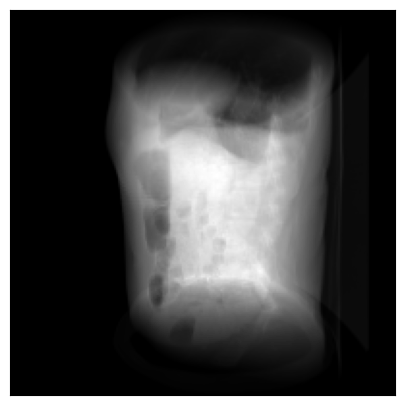

In [26]:
# Plot the DRR
plot_drr(img_liver, ticks=False)
plt.show()